# End-to-End Machine Learning Project

#In this chapter, you will go through an example project end to end, pretending to be a
recently hired data scientist in a real estate company.
 Here are the main steps you will
go through:
1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

# Look at the Big Picture


The first task you are asked to perform is to build a model of housing prices in California using the California census data.This data has metrics such as the population, median income, median hous‐
ing price, and so on for each block group in California. Block groups are the smallest
geographical unit for which the US Census Bureau publishes sample data (a block
group typically has a population of 600 to 3,000 people). We will just call them “dis‐
tricts” for short

##Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics

# 1- Frame the Problem

The first question to ask your boss is what exactly is the business objective; building a
model is probably not the end goal. How does the company expect to use and benefit from this model? This is important because it will determine how you frame the
problem, what algorithms you will select, what performance measure you will use to
evaluate your model, and how much effort you should spend tweaking it.
Your boss answers that your model’s output (a prediction of a district’s median hous‐
ing price) will be fed to another Machine Learning system

The next question to ask is what the current solution looks like (if any). It will often
give you a reference performance, as well as insights on how to solve the problem.
Your boss answers that the district housing prices are currently estimated manually
by experts: a team gathers up-to-date information about a district, and when they
cannot get the median housing price, they estimate it using complex rules.


Okay, with all this information you are now ready to start designing your system.
First, you need to frame the problem: is it supervised, unsupervised, or Reinforce‐
ment Learning? Is it a classification task, a regression task, or something else? Should
you use batch learning or online learning techniques?

Let’s see: it is clearly a typical supervised learning task
since you are given labeled training examples (each instance comes with the expected
output, i.e., the district’s median housing price). Moreover, it is also a typical regres‐
sion task, since you are asked to predict a value. More specifically, this is a multiple
regression problem since the system will use multiple features to make a prediction (it
will use the district’s population, the median income, etc.). It is also a univariate
regression problem since we are only trying to predict a single value for each district.
If we were trying to predict multiple values per district, it would be a multivariate
regression problem. Finally, there is no continuous flow of data coming in the system,
there is no particular need to adjust to changing data rapidly, and the data is small
enough to fit in memory, so plain batch learning should do just fine.


# 2- Select a Performance Measure

#Root mean square :
$(\sqrt{\frac{1}{m}\sum\nolimits_{i=1}^m(h(x^i) -y^i )^2}$

#Mean Absolute Erro:
$(\frac{1}{m}\sum\nolimits_{i=1}^m|(h(x^i) -y^i )|$

# 3-Check the Assumptions


Lastly, it is good practice to list and verify the assumptions that were made so far (by
you or others); this can catch serious issues early on. For example, the district prices
that your system outputs are going to be fed into a downstream Machine Learning
system, and we assume that these prices are going to be used as such. But what if the
downstream system actually converts the prices into categories (e.g., “cheap,”
“medium,” or “expensive”) and then uses those categories instead of the prices them‐
selves? In this case, getting the price perfectly right is not important at all; your sys‐
tem just needs to get the category right. If that’s so, then the problem should have
been framed as a classification task, not a regression task. You don’t want to find this
out after working on a regression system for months.
Fortunately, after talking with the team in charge of the downstream system, you are
confident that they do indeed need the actual prices, not just categories. Great! You’re
all set, the lights are green, and you can start coding now!

# Get the Data

In [1]:
import pandas as pd

housing = pd.read_csv("housing.csv")


housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset, which means that it is fairly small by
Machine Learning standards, but it’s perfect to get started. Notice that the total_bed
rooms attribute has only 20,433 non-null values, meaning that 207 districts are miss‐
ing this feature. We will need to take care of this later.

All attributes are numerical, except the ocean_proximity field. Its type is object, so it
could hold any kind of Python object, but since you loaded this data from a CSV file
you know that it must be a text attribute. When you looked at the top five rows, you
probably noticed that the values in the ocean_proximity column were repetitive,
which means that it is probably a categorical attribute. You can find out what cate‐
gories exist and how many districts belong to each category by using the
value_counts() method:

In [3]:
#I want to know the vlues in column "ocean_proximity" to convert it to numbers.
housing["ocean_proximity"].value_counts()
#housing.value_counts(housing["ocean_proximity"] , normalize=True ,ascending=True)

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another quick way to get a feel of the type of data you are dealing with is to plot a 
histogram for each numerical attribute. A histogram shows the number of instances
(on the vertical axis) that have a given value range (on the horizontal axis). You can
either plot this one attribute at a time, or you can call the hist() method on the
whole dataset, and it will plot a histogram for each numerical attribute (see
Figure 2-8). For example, you can see that slightly over 800 districts have a
median_house_value equal to about $100,000.


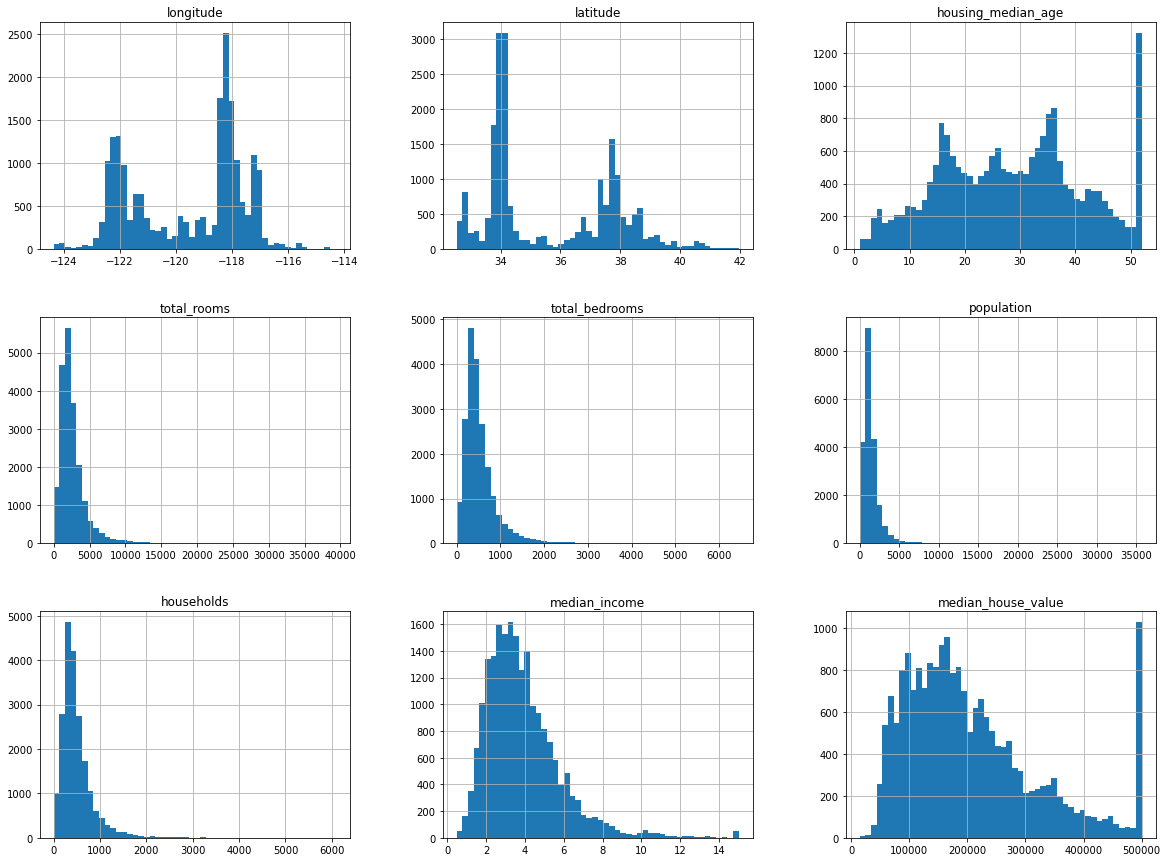

In [5]:
# only in a Jupyter notebook %matplotlib inline 
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

# Notice a few things in these histograms:
1. First, the median income attribute does not look like it is expressed in US dollars(USD).
After checking with the team that collected the data, you are told that the
data has been scaled and capped at 15 (actually 15.0001) for higher median
incomes, and at 0.5 (actually 0.4999) for lower median incomes. The numbers
represent roughly tens of thousands of dollars (e.g., 3 actually means about
$30,000).

2. The housing median age and the median house value were also capped. The lat‐
ter may be a serious problem since it is your target attribute (your labels). Your
Machine Learning algorithms may learn that prices never go beyond that limit.
You need to check with your client team (the team that will use your system’s out‐
put) to see if this is a problem or not. If they tell you that they need precise pre‐
dictions even beyond $500,000, then you have mainly two options:
a. Collect proper labels for the districts whose labels were capped.
b. Remove those districts from the training set (and also from the test set, since
your system should not be evaluated poorly if it predicts values beyond
$500,000).

3. These attributes have very different scales.

4. Finally, many histograms are tail heavy: they extend much farther to the right of
the median than to the left. This may make it a bit harder for some Machine
Learning algorithms to detect patterns. We will try transforming these attributes
later on to have more bell-shaped distributions.

# Create a Test Set


In [6]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


<AxesSubplot:>

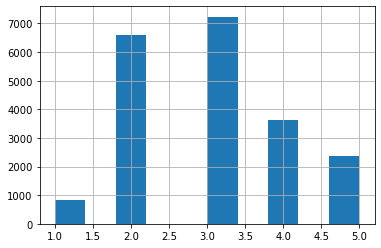

In [7]:
#you think the median income is the important column to determine the output(median_house_value)
#make new column (income_cat) based on values in ("median_income")
import numpy as np 
#print(np.inf) = inifinity
housing["income_cat"] = pd.cut(housing["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [8]:
"""what i want to do ??
->split date in train/test set but i want to ensure I split the values in income_cat that based
on median income
(important) on train/test set (distribution all values in income_cat on all train/tes set)
"""
"""
Now you are ready to do stratified sampling based on the income category. For this
you can use Scikit-Learn’s StratifiedShuffleSplit class:
if you don't understand what the StratifiedShuffleSplit doing take alool on the file dicussion
"""
#split date and shuffle it 
from sklearn.model_selection import StratifiedShuffleSplit
#object 
spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

#spliter.get_n_splits(housing, housing["income_cat"]) =1 


In [9]:
"""
using for loop to return indexs of train/test set in housing 
X=housing ,y = housing['incoms_cat'] 
"""
for train_index, test_index in spliter.split(housing, housing["income_cat"]):
    stratified_train_set = housing.loc[train_index]
    stratified_test_set = housing.loc[test_index]
    
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


In [10]:
#after we split data by using StratifiedShuffleSplit() 
#we must make some tests to ensure the data is better than splitting using train_test_split()
stratified_test_set["income_cat"].value_counts(normalize= True)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [11]:
X_train,X_test,y_train,y_test= train_test_split(housing,housing["income_cat"], test_size=0.2, random_state=42)
#random
X_test["income_cat"].value_counts(normalize= True)

3    0.358527
2    0.324370
4    0.167393
5    0.109496
1    0.040213
Name: income_cat, dtype: float64

In [12]:
#as we saw no big change happened in values
#Now you should remove the income_cat attribute so the data is back to its origin/al
for set_ in (stratified_train_set, stratified_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


# Discover and Visualize the Data to Gain Insights
First, make sure you have put the test set aside and you are only exploring the train‐
ing set. Also, if the training set is very large, you may want to sample an exploration
set, to make manipulations easy and fast. In our case, the set is quite small so you can
just work directly on the full set. Let’s create a copy so you can play with it without
harming the training set


In [13]:
housing = stratified_train_set.copy()
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


# Visualizing Geographical Data
Since there is geographical information (latitude and longitude), it is a good idea to
create a scatterplot of all districts to visualize the data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

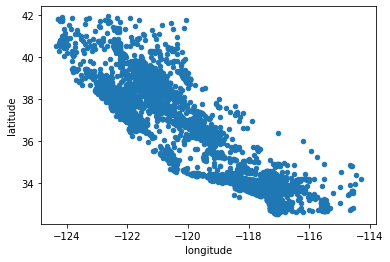

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Setting the alpha option to 0.1 makes it much easier to visualize the places
where there is a high density of data points

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

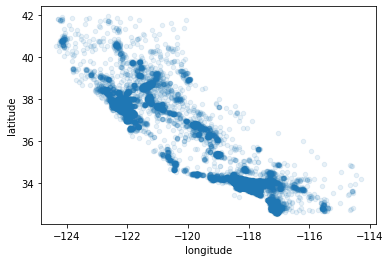

In [15]:
housing.plot(kind="scatter", x="longitude", y="latitude",alpha=0.1)

Now let’s look at the housing prices . The radius of each circle represents
the district’s population (option s), and the color represents the price (option c). We
will use a predefined color map (option cmap) called jet, which ranges from blue
(low values) to red (high prices):

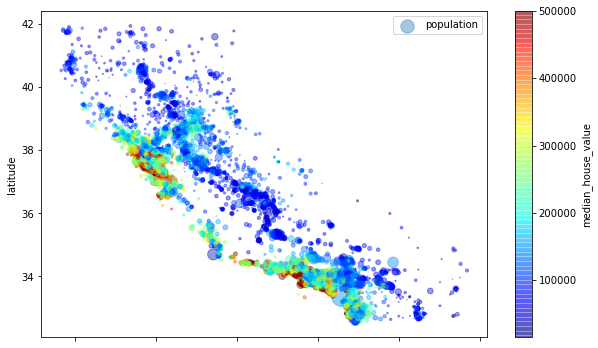

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,6),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()


# Looking for Correlations
Since the dataset is not too large, you can easily compute the standard correlation
coecient (also called Pearson’s r) between every pair of attributes using the corr()
method.
Pandas dataframe.corr() is used to find the pairwise correlation of all columns in the dataframe. Any na values are automatically excluded. For any non-numeric data type columns in the dataframe it is ignored.

https://www.geeksforgeeks.org/python-pandas-dataframe-corr/

In [17]:
corr_matrix = housing.corr()


#print correlatin between ["median_house_value"] with all column 

#print(corr_matrix["median_house_value"].sort_values(ascending=False))

"""
The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that
there is a strong positive correlation;
"""
#housing.head()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [18]:
print(corr_matrix["median_house_value"].sort_values(ascending=False))


median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64


# Another way: 
to check for correlation between attributes is to use Pandas’
scatter_matrix function, which plots every numerical attribute against every other
numerical attribute. Since there are now 11 numerical attributes, you would get 11**2=121 plots

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

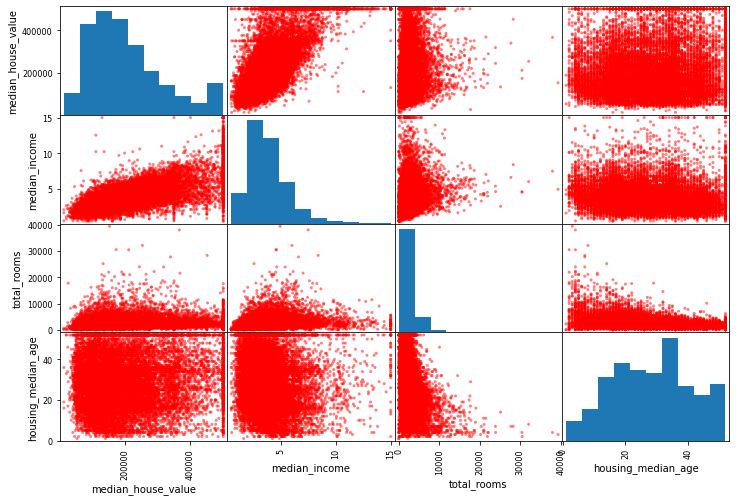

In [19]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
 "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8),color='r')

#The most promising attribute to predict the median house value is the median
income, so let’s zoom in on their correlation scatterplot.
#The next plot reveals a few things. First, the correlation is indeed very strong; you can
clearly see the upward trend and the points are not too dispersed

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

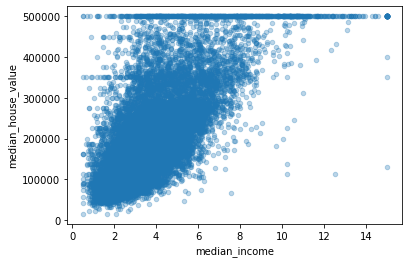

In [20]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
 alpha=0.3)

# Experimenting with Attribute Combinations
- You identified a few data quirks that you may want to clean up before feeding the data to a Machine Learning algorithm.

- you found interesting correlations between attributes, in particular with the target attribute. 

- You noticed that some attributes have a tail-heavy distribution, so you may want to trans‐
form them (e.g., by computing their logarithm).

- try out various attribute combinations.


In [21]:
#total number of rooms in a district is not very useful
#the total number of bedrooms by itself is not very useful.

"""
what i will want to do??
-the number of rooms per household.
-compare total of bedrooms to the number of rooms.
-find population per household.

"""
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [22]:
#the number of rooms per household.
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

#compare total of bedrooms to the number of rooms.
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

#find population per household.
housing["population_per_household"]=housing["population"]/housing["households"]


In [23]:
#let’s look at the correlation matrix again:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
#we see the rooms

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# New correlation:
The new bedrooms_per_room attribute is much more correlated with
the median house value than the total number of rooms or bedrooms. Apparently
houses with a lower bedroom/room ratio tend to be more expensive. The number of
rooms per household is also more informative than the total number of rooms in a
district—obviously the larger the houses, the more expensive they are.


<AxesSubplot:xlabel='median_income', ylabel='bedrooms_per_room'>

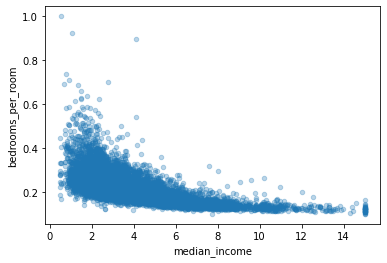

In [24]:
#to understand correlation we plot it
housing.plot(kind="scatter", x="median_income", y="bedrooms_per_room",
 alpha=0.3)

<AxesSubplot:xlabel='median_income', ylabel='rooms_per_household'>

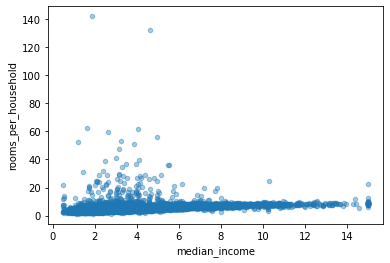

In [25]:
#to understand correlation we plot it
housing.plot(kind="scatter", x="median_income", y="rooms_per_household",
 alpha=0.4)

# Prepare the Data for Machine Learning Algorithms
first let’s revert to a clean training set (by copying strat_train_set once again),
and let’s separate the predictors and the labels since we don’t necessarily want to apply
the same transformations to the predictors and the target values (note that drop()
creates a copy of the data and does not affect strat_train_set):

In [26]:
# X = housing
housing = stratified_train_set.drop("median_house_value", axis=1)
# y = housing_labels
housing_labels = stratified_train_set["median_house_value"].copy()


# Data Cleaning:
Most Machine Learning algorithms cannot work with missing features, so let’s create
a few functions to take care of them. You noticed earlier that the total_bedrooms
attribute has some missing values, so let’s fix this.

## Scikit-Learn :
provides a handy class to take care of missing values: SimpleImputer.
Here is how to use it. First, you need to create a SimpleImputer instance, specifying
that you want to replace each attribute’s missing values with the median of that
attribute

In [27]:
from sklearn.impute import SimpleImputer

#build object
imputer = SimpleImputer(strategy="median")

"""
Since the median can only be computed on numerical attributes, we need to create a
copy of the data without the text attribute ocean_proximity:
"""
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

"""
The imputer has simply computed the median of each attribute and stored the result
in its statistics_ instance variable
"""
print("the median values for all columns :")
for (med ,col) in zip(imputer.statistics_,housing_num.columns) :
    print(col,"=",med)

the median values for all columns :
longitude = -118.51
latitude = 34.26
housing_median_age = 29.0
total_rooms = 2119.5
total_bedrooms = 433.0
population = 1164.0
households = 408.0
median_income = 3.5408999999999997


In [28]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [29]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [30]:
#we saw above the total_bedrooms is 16354 no changes happened
X = imputer.transform(housing_num)
"""
The result is a plain NumPy array containing the transformed features. If you want to
put it back into a Pandas DataFrame, it’s simple:
"""
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.info()
#we see all values in columns not null untill in total_bedrooms after we
#apply transform fun .

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


# Handling Text and Categorical Attributes:
Earlier we left out the categorical attribute ocean_proximity because it is a text
attribute so we cannot compute its median:


In [31]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)


,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


 Most Machine Learning algorithms prefer to work with numbers anyway, so let’s con‐
vert these categories from text to numbers. For this, we can use Scikit-Learn’s Ordina
lEncoder class:

#  sklearn.preprocessing.OrdinalEncoder:
class sklearn.preprocessing.OrdinalEncoder(categories=’auto’, dtype=<class
                                            ‘numpy.float64’>)
Encode categorical features as an integer array.
The input to this transformer should be an array-like of integers or strings, denoting the values taken on by
categorical (discrete) features. The features are converted to ordinal integers. This results in a single column of
integers (0 to n_categories - 1) per feature.


In [32]:
from sklearn.preprocessing import OrdinalEncoder

#build object from ordinalEncoder class
ordinal_encoder = OrdinalEncoder()

In [33]:
#transform values in "ocean_proximitry" to number 0,1,2,3,4
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]        

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [34]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# oneHotEncoder:
 with this representation is that ML algorithms will assume that two nearby
values are more similar than two distant values. This may be fine in some cases (e.g.,
for ordered categories such as “bad”, “average”, “good”, “excellent”), but it is obviously
not the case for the ocean_proximity column (for example, categories 0 and 4 are
clearly more similar than categories 0 and 1). To fix this issue, a common solution is
to create one binary attribute per category: one attribute equal to 1 when the category
is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is
“INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because
only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new
attributes are sometimes called dummy attributes. Scikit-Learn provides a OneHotEn
coder class to convert categorical values into one-hot vectors

In [35]:
#import class 
from sklearn.preprocessing import OneHotEncoder

#make object 
cat_encoder = OneHotEncoder()

#know the shape of housing_cat befor transform
print("housing_cat befor transform:",housing_cat.shape)

#convert housing_cat values to 0,1
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

#know the shape of housing_cat befor transform
print("housing_cat after transform:",housing_cat_1hot.shape)


housing_cat befor transform: (16512, 1)
housing_cat after transform: (16512, 5)


In [36]:
#Notice that the output is a SciPy sparse matrix, instead of a NumPy array.
print(type(housing_cat_1hot))

<class 'scipy.sparse.csr.csr_matrix'>


In [37]:
#convert to  NumPy array
housing_cat_1hot.toarray()


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

BaseEstimator provides among other things a default implementation for the get_params and set_params methods.
The central piece of transformer, regressor, and classifier is sklearn.base.BaseEstimator. All estimators in scikit-learn are derived from this class. In more details, this base class enables to set and get parameters of the estimator

Transformer
Transformers are scikit-learn estimators which implement a transform method. The use case is the following:

at fit, some parameters can be learned from X and y;

at transform, X will be transformed, using the parameters learned during fit.

In addition, scikit-learn provides a mixin, i.e. sklearn.base.TransformerMixin, which implement the combination of fit and transform called fit_transform:

One can import the mixin class as:

Therefore, when creating a transformer, you need to create a class which inherits from both sklearn.base.BaseEstimator and sklearn.base.TransformerMixin. The scikit-learn API imposed fit to return ``self``. The reason is that it allows to pipeline fit and transform imposed by the sklearn.base.TransformerMixin. The fit method is expected to have X and y as inputs. Note that transform takes only X as input and is expected to return the transformed version of X:

In [63]:


from sklearn.base import BaseEstimator, TransformerMixin
#index of columns in data.
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
         self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
         return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
print(housing.shape)
housing_extra_attribs = attr_adder.transform(housing.values)
print(housing_extra_attribs.shape)
housing.head(3)


(16512, 9)
(16512, 11)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN


In [64]:
#convert housing to dataframe
housingg=housing.copy()
housingg['rooms_per_household']  =None
housingg['population_per_household'] =None
housing_extra_attribs_new=pd.DataFrame(housing_extra_attribs,columns =housingg.columns)
housing_extra_attribs_new.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597


# Feature Scaling:
One of the most important transformations you need to apply to your data is feature
scaling. With few exceptions, Machine Learning algorithms don’t perform well when
the input numerical attributes have very different scales. This is the case for the hous‐
ing data: the total number of rooms ranges from about 6 to 39,320, while the median
incomes only range from 0 to 15. Note that scaling the target values is generally not
required.

#### 2 common ways to get all attributes to have the same scale:min-maxscaling,standardization.
Min-max scaling  =  subtract‐ing the min value and dividing by the max minus the min.

### Scikit-Learn provides a transformer called MinMaxScaler for this

Standardization is quite different: first it subtracts the mean value (so standardized
values always have a zero mean), and then it divides by the standard deviation so that
the resulting distribution has unit variance

#  Transformation Pipelines:
    Scikit-Learn provides the Pipeline class to help with
    such sequences of transformations. Here is a small pipeline for the numerical
    attributes:

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
 ('imputer', SimpleImputer(strategy="median")),
 ('attribs_adder', CombinedAttributesAdder()),
 ('std_scaler', StandardScaler()),
 ])
print(housing_num.shape)
housing_num_tr = num_pipeline.fit_transform(housing_num)
(housing_num_tr.shape)

(16512, 8)


(16512, 11)

In [41]:
from sklearn.compose import ColumnTransformer
#columnTransformer apply on all columns
num_attribs = list(housing_num)
print(num_attribs)
print("=======================")
cat_attribs = ["ocean_proximity"]
print(cat_attribs)
print("=======================")
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])
print(housing.columns)
print("=======================")
housing_prepared = full_pipeline.fit_transform(housing)
print(type(housing_prepared))
print(housing_prepared.shape)
"""
housing = 9 columns
housing_num = 8 columns
houssing_num_tr= 11 columns
cat_attribs = 1 column
cat_attribs after apply oneHotEncoder on it.that transfer from one to 5colums.
housing_prepared = housing_num_tr + oneHotEnocoder(cat_attribs) =11+5=16

"""

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
['ocean_proximity']
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')
<class 'numpy.ndarray'>
(16512, 16)


'\nhousing = 9 columns\nhousing_num = 8 columns\nhoussing_num_tr= 11 columns\ncat_attribs = 1 column\ncat_attribs after apply oneHotEncoder on it.that transfer from one to 5colums.\nhousing_prepared = housing_num_tr + oneHotEnocoder(cat_attribs) =11+5=16\n\n'

# Training and Evaluating on the Training Set


In [65]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
#housing_labels = median_house_value =y
#housing_prepared = X = data after apply some preprocessing technique.
lin_reg.fit(housing_prepared, housing_labels)

lin_reg.predict(housing_prepared)


array([210644.60459286, 317768.80697211, 210956.43331178, ...,
        95464.57062437, 214353.22541713, 276426.4692067 ])

In [66]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_mse
print(type(housing_predictions))
print(type(housing_labels))

a = lin_reg.score(housing_prepared,housing_labels)
print(a)

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
0.6481624842804428


In [67]:
np.sqrt(lin_mse)

68628.19819848923

In [68]:
housing_labels.describe()
#50% of data is between 119800 ->263900

count     16512.000000
mean     206990.920724
std      115703.014830
min       14999.000000
25%      119800.000000
50%      179500.000000
75%      263900.000000
max      500001.000000
Name: median_house_value, dtype: float64

Okay, this is better than nothing but clearly not a great score: most districts’
median_housing_values range between $120,000 and $265,000, so a typical predic‐
tion error of $68,628 is not very satisfying.(under fitting problem)

Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding
complex nonlinear relationships in the data 

In [46]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

#test the model
housing_predictions = tree_reg.predict(housing_prepared)
print(tree_reg.score(housing_prepared,housing_labels))
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1.0


0.0

Wait, what!? No error at all? Could this model really be absolutely perfect? Of course,
it is much more likely that the model has badly overfit the data. How can you be sure?
As we saw earlier, you don’t want to touch the test set until you are ready to launch a
model you are confident about, so you need to use part of the training set for train‐
ing, and part for model validation

# Better Evaluation Using Cross-Validation
One way to evaluate the Decision Tree model would be to use the train_test_split
function to split the training set into a smaller training set and a validation set.
 great alternative is to use Scikit-Learn’s K-fold cross-validation feature.

In [61]:
"""
cross_val_score(
    estimator,
    X,
    y=None,
    *,
    groups=None,
    scoring=None,
    cv=None,
    n_jobs=None,
    verbose=0,
    fit_params=None,
    pre_dispatch='2*n_jobs',
    error_score=nan,
)
"""

"\ncross_val_score(\n    estimator,\n    X,\n    y=None,\n    *,\n    groups=None,\n    scoring=None,\n    cv=None,\n    n_jobs=None,\n    verbose=0,\n    fit_params=None,\n    pre_dispatch='2*n_jobs',\n    error_score=nan,\n)\n"

In [62]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
 scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
#the value is negative in scores 
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

Scores: [67680.63523903 67461.19527971 70940.42152636 68784.32755579
 71284.1123461  76055.71120133 70751.12722973 70836.25919857
 76443.83979474 69406.78627411]
Mean: 70964.44156454576
Standard deviation: 2938.4492029888092


#### Let’s compute the same scores for the Linear Regression model just to be sure:
 

In [49]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
      scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983493


In [69]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
      scoring="neg_mean_squared_error", cv=10)


In [51]:
forest_rmse =np.sqrt(-forest_scores)
display_scores(forest_rmse)

Scores: [49733.89406427 47304.62177167 50206.18191997 52378.58376877
 49737.27829196 53157.15077774 48866.96713913 48020.92345097
 52948.64319757 50088.00945922]
Mean: 50244.22538412755
Standard deviation: 1907.3269531179933


# Fine-Tune Your Model
Let’s assume that you now have a shortlist of promising models. You now need to
fine-tune them. Let’s look at a few ways you can do that.

In [70]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
 scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [71]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [72]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

# Evaluate Your System on the Test Set

In [73]:
final_model = grid_search.best_estimator_
X_test = stratified_test_set.drop("median_house_value", axis=1)
y_test = stratified_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) # => evaluates to 47,730.2


In [56]:
final_rmse

48191.733732017434